# Brain Tissue Classification

## Learning Objective

The goal of this project is to demonstate that jupyter notebooks
is a powerful tool for quickly prototyping ideas. Jupyter notebooks allow for quick visualization
of both data and results in real time. The effects of preprocessubg 
the data and tuning algorithm parameters can easily be observed. 

This notebook demonstrates the notebook features by segmenting brain regions
using machine learning on multi modal brain MRI images. However, the
the applications our endless. The focus should not be on machine learning,
but rather what jupyter notebooks are capable of doing.



In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Import Modules
import itk
itk.force_load() #Load everything at once, slow but maximizes introspection

import glob
import os
import numpy as np
import pandas as pd                                 #pip install pandas
from sklearn.naive_bayes import GaussianNB          #pip install sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import tree
#from sklearn.model_selection.cross_validation import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib import gridspec

from itkwidgets import view

from ipywidgets import interact, fixed
from ipywidgets import interactive
import ipywidgets as widgets

# Read Images

In [3]:
# Image Filenames
t1_fn = "t1_average_BRAINSABC.nii.gz"
t2_fn = "t2_average_BRAINSABC.nii.gz"
lbl_fn = "labels.nii.gz"

# Read images 
t1_img = itk.imread(t1_fn)
t2_img = itk.imread(t2_fn)
lbl_img = itk.imread(lbl_fn)

# Define labels
LABELS = dict()
LABELS["WM"] = [1]
LABELS["GM"] = [2]
LABELS["CSF"] = [4]

# Data Preprocessing

It is almost always necessary to perform preprocessing on the data before using it. Here we will focus on two preprocessing methods.

First, we will use smoothing filtes to reduce noise in the image. It is critical to find a good scale that balances the tradeoff between smoothing noise and loosing information. The notebook makes it easy to see the effects of different smoothing levels. 

Second, we will pick a sub sample of the image pixels to use for training a model. To do this we will erode the label map. The notebook allows us to see what radius to use for the erosion kernel, we don't want to completely erode a label!

In [4]:
from medianhelper import MedianFilter  ## See content from file medianhelper
# Median widget helper
median_instance = MedianFilter(t1_img)
widgets.VBox([median_instance.viewer, median_instance.slider])

In [5]:
#help(itk.BinaryErodeImageFilter.New(lbl_img))
from erodehelper import ErodeLabels
label_map = {'WM' : [1],
             'GM' : [2],
             'CSF' : [4],
             'All' : [1,2,4]}

# Erosion widget
erode_instance = ErodeLabels(lbl_img)
widgets.VBox([erode_instance.viewer, erode_instance.slider])


In [6]:
from plothelper import PlotClassDistribution
LABELSDICT = {'WM': 1, 'GM':2, 'CSF':4}
# 2D histogram widget
plotter = PlotClassDistribution(t1_img, t2_img, lbl_img, LABELSDICT)
interact(plotter.display,
         erode_radius=(erode_instance.min_radius, erode_instance.max_radius),
         median_radius=(median_instance.min_radius, median_instance.max_radius)
        )

Median filter with size 0 took 2.6226043701171875e-06 seconds to evaluate
Median filter with size 1 took 0.31858181953430176 seconds to evaluate
Median filter with size 2 took 1.4992847442626953 seconds to evaluate
Median filter with size 0 took 2.86102294921875e-06 seconds to evaluate
Median filter with size 1 took 0.38440966606140137 seconds to evaluate
Median filter with size 2 took 1.5427298545837402 seconds to evaluate


interactive(children=(IntSlider(value=0, description='erode_radius', max=4), IntSlider(value=0, description='m…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

Based on the what your observations from the above widgets, preprocess the data to obtain a dataset that will be used to train a model for brain tissue classification. 

In [7]:
############################
####### FILL IN ############
############################
# smooth image
t1_img_smooth = t1_img
t2_img_smooth = t2_img

# erode label map
lbl_img_erode = lbl_img
############################


# Machine Learning

In [13]:
from mlhelper import niave_gaussian_probabilities ,  knn_probabilities, dt_probabilities, plot_decision_boundary


## Get Features Vectors

In [14]:
from mlhelper import get_random_sample, get_accuracy


In [15]:
from utilityfunctions import flatten_image

# Flatten images to 1D numpy array
t1_np1d = flatten_image(t1_img_smooth)
t2_np1d = flatten_image(t2_img_smooth)
lbl_np1d = flatten_image(lbl_img_erode)
lbl_np1d_orig = flatten_image(lbl_img)

# Take equal subsample from each class for training
num=97      #NOTE:  97 is a relatively small number of samples choosen for speed.  Try other values (i.e. 300, 4000, 100000)
train, train_labels = get_random_sample(t1_np1d, t2_np1d, lbl_np1d,LABELSDICT,num)
# Use entire image for testing
test = np.column_stack((t1_np1d,t2_np1d))


In the plots that follow, the blue regions indicate the high probability for that class, and the red regions indicate low probability for that class.

In [16]:
def model_callback(model, models):
    """Plots the decision boundary for different classifiers
    
    Args:
      model : Key of dictionary corresponding to a model
      models (dict): dictionary of trained models
      class_labels (dict): a dictionary mapping class_labels to numerical values.
    """
    plot_decision_boundary(models[model],train[:,0], train[:,1], train_labels, LABELSDICT)
    
dt_probs, dt_model = dt_probabilities(test, train, train_labels)    
knn_probs, knn_model = knn_probabilities(test,train, train_labels, 5)
nb_probs, nb_model = niave_gaussian_probabilities(test, train, train_labels)

model_dict = {'knn':knn_model, 'naive_bayes':nb_model, 'decision_tree':dt_model}
print("HERE: {0}".format(LABELSDICT))
interact(model_callback, model=['naive_bayes','decision_tree','knn'], models = fixed(model_dict))


HERE: {'WM': 1, 'GM': 2, 'CSF': 4}


interactive(children=(Dropdown(description='model', options=('naive_bayes', 'decision_tree', 'knn'), value='na…

<function __main__.model_callback(model, models)>

In [17]:
# Predict using Decision Tree model
dt_predict_train = dt_model.predict(train)
dt_predict_test = dt_model.predict(test)
dt_train_acc = get_accuracy(dt_predict_train, train_labels)
dt_test_acc = get_accuracy(dt_predict_test, lbl_np1d_orig)

# Predict using kNN model
knn_predict_train = knn_model.predict(train)
knn_predict_test = knn_model.predict(test)
knn_train_acc = get_accuracy(knn_predict_train, train_labels)
knn_test_acc = get_accuracy(knn_predict_test, lbl_np1d_orig)

# Predict using Naive Bayes model
nb_predict_train = nb_model.predict(train)
nb_predict_test = nb_model.predict(test)
nb_train_acc_train = get_accuracy(nb_predict_train, train_labels)
nb_test_acc = get_accuracy(nb_predict_test, lbl_np1d_orig)


Text(0.5, 1.0, 'Accuracy for different Classification Models')

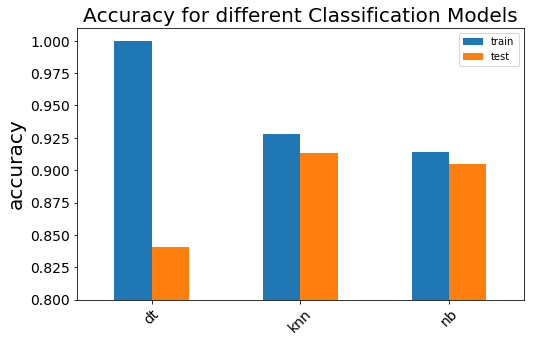

In [18]:
# Plot results
df = pd.DataFrame([[dt_train_acc,dt_test_acc], 
                   [knn_train_acc,knn_test_acc],
                   [nb_train_acc_train, nb_test_acc]], 
                  index = ['dt','knn', 'nb'],
                  columns = ['train','test'])
df.plot(kind='bar',figsize=(8,5), fontsize=14)

plt.ylabel("accuracy",fontsize=20)
plt.xticks(rotation=45)
plt.ylim([0.80,1.01])
plt.title("Accuracy for different Classification Models",fontsize=20)

In [19]:
def knn_callback(k=1):
    """Plots the decision boundary for kNN classifer for different k
    
    Args:
      k (int): Number of neighbors for kNN classifer
 
    """
    if k not in knn_pred_cache:
        all_probs, y_pred = knn_probabilities(test, train, train_labels, k)
        knn_pred_cache[k] = y_pred
    Z = knn_pred_cache[k]
    plot_decision_boundary(Z,train[:,0], train[:,1], train_labels, LABELSDICT)
    print('k = ' + str(k))
    
knn_pred_cache = dict()
interact(knn_callback, k = (1,9,2))

interactive(children=(IntSlider(value=1, description='k', max=9, min=1, step=2), Output()), _dom_classes=('wid…

<function __main__.knn_callback(k=1)>

In [20]:
def dt_callback(d=1):
    """Plots the decision boundary for kNN classifer for different k
    
    Args:
      k (int): Number of neighbors for kNN classifer
 
    """
    if d not in dt_pred_cache:
        all_probs, y_pred = dt_probabilities(test, train, train_labels, d)
        dt_pred_cache[d] = y_pred
    Z = dt_pred_cache[d]
    plot_decision_boundary(Z,train[:,0], train[:,1], train_labels, LABELSDICT)
    print('d = ' + str(d))
    
dt_pred_cache = dict()
interact(dt_callback, d = (1,9))

interactive(children=(IntSlider(value=1, description='d', max=9, min=1), Output()), _dom_classes=('widget-inte…

<function __main__.dt_callback(d=1)>

In [ ]:
# Get accuracies for different k
knn_accuracies = []
for k in range(1,10,2):
    if k not in knn_pred_cache:
        all_probs, model = knn_probabilities(test, train, train_labels, k)
        knn_pred_cache[k] = model
    pred = knn_pred_cache[k].predict(test)
    pred_train = knn_pred_cache[k].predict(train)
    accuracy = get_accuracy(pred, lbl_np1d_orig)
    accuracy_train = get_accuracy(pred_train, train_labels)
    knn_accuracies.append([accuracy_train,accuracy])

In [ ]:
# Plot results
knn_df = pd.DataFrame(knn_accuracies, index=['k=1','k=3','k=5','k=7','k=9'], columns = ['train','test'])
knn_df.plot(kind='bar', figsize=(8,5), fontsize=14)
#knn_df.plot(figsize=(8,5), fontsize=14)
plt.ylim([0.80,1.01])
plt.ylabel("accuracy", fontsize=20)
plt.xticks(rotation=45)
plt.title("kNN Accuracy for different k",fontsize=20)


In [ ]:
# Get accuracies for different max tree depth
dt_accuracies = []
for d in range(1,10):
    if d not in dt_pred_cache:
      all_probs, model = dt_probabilities(test, train, train_labels, d)
      dt_pred_cache[d] = model
    pred = dt_pred_cache[d].predict(test)
    pred_train = dt_pred_cache[d].predict(train)
    acc = get_accuracy(pred, lbl_np1d_orig)
    acc_train = get_accuracy(pred_train, train_labels)
    dt_accuracies.append([acc_train,acc])

In [ ]:
# Plot results
dt_df = pd.DataFrame(dt_accuracies,columns=['train','test'], index =range(1,10) )
dt_df.plot(figsize=(8,5), fontsize=14)
plt.ylim([0.5,0.95])
plt.xlabel("tree depth", fontsize=20)
plt.ylabel("accuracy",fontsize=20)
plt.title("Accuracy for different tree depth",fontsize=20)


In [ ]:
#choose a model, train and predict

all_probs, model = niave_gaussian_probabilities(test, train, train_labels)

pred_test_np1d = model.predict(test)
pred_train_np1d = model.predict(train)

# set background prediction to zero
pred_test_np1d[lbl_np1d_orig==0]=0

In [98]:
imsize=lbl_img.GetLargestPossibleRegion().GetSize()
pred = pred_test_np1d.reshape((imsize[2], imsize[1], imsize[0])).astype(np.float32)
pred_img = itk.GetImageFromArray(pred)
pred_img.CopyInformation(lbl_img)
pred_np1d = flatten_image(pred_img)
cif = itk.CastImageFilter[pred_img, itk.Image[itk.UC,3]].New(Input=pred_img)
pred_img= cif.GetOutput()


In [112]:
# Calculate the accuracy of your model

accuracy_test = get_accuracy(pred_test_np1d, lbl_np1d_orig)
accuracy_train = get_accuracy(pred_train_np1d, train_labels)

print(accuracy_test)
print(accuracy_train)


0.9069759731383816
0.9347079037800687


In [113]:
from scipy.stats import ttest_ind

ttest_ind(pred_train_np1d, train_labels)

Ttest_indResult(statistic=0.16556216275244748, pvalue=0.868559217203358)

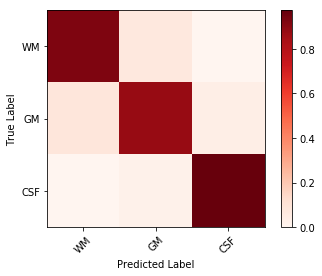

In [114]:
#confusion matrix
def show_confusion_matrix(prediction_np1d, labels_np1d):
    """Calculates confusion matrix for the trained classifier
    
    Args:
      prediction_np1d (np.array) : model prediction
      labels_np1d (np.array) : ground truth labels
 
    """
    m = confusion_matrix(labels_np1d, prediction_np1d)
    
    # normalize each row
    m = m.astype('float')/m.sum(axis=1)[:,np.newaxis]
    # remove background labels
    m = m[1:,:]
    m = m[:,1:]
    fig = plt.figure()
    plt.imshow(m, interpolation='nearest', cmap = plt.cm.Reds)
    plt.colorbar()
    tick_marks = np.arange(3)
    plt.xticks(tick_marks, ['WM','GM','CSF'], rotation=45)
    plt.yticks(tick_marks, ['WM','GM','CSF'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
show_confusion_matrix(pred_test_np1d, lbl_np1d_orig)

which model and why
any preprocessing?
training and testing accuracies
